## CAP 5571 - Data Mining Approach to Target Customers for Marketing Campaigns Based on Customer Segmentation

In [40]:
#Importing tools
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import datetime as dt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
#Loading the dataset
data = pd.read_excel("Online_Retail.xlsx")
data.shape

(541909, 8)

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#Checking for missing values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data.Country.value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [6]:
#Guest orders donot have Customer ID

In [7]:
data['CustomerID'].fillna(0, inplace=True)

In [8]:
data[data['CustomerID'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,0.0,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,0.0,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,0.0,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,0.0,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,0.0,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,0.0,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,0.0,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,0.0,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,0.0,United Kingdom


In [9]:
#Replacing null CustomerID's of guest customers with InvoiceNo
for i in range(len(data)):
    if data['CustomerID'][i] == 0:
        data['CustomerID'][i] = data['InvoiceNo'][i]

In [10]:
customer_data = data.groupby(['CustomerID'], as_index=False).agg({'UnitPrice':'sum'})
customer_data.shape

(8082, 2)

In [11]:
data['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [12]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [13]:
#Creating Recency, frequency and Monetary value columns from the current attributes in the data
PRESENT = dt.datetime(2012,1,1)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['year'] = data['InvoiceDate'].dt.year
data['previous_visit'] = data.groupby(['CustomerID', 'year'])['InvoiceDate'].shift()
data['days_bw_visit'] = data['InvoiceDate'] - data['previous_visit']
data['days_bw_visit'] = data['days_bw_visit'].apply(lambda x: x.days)
data['Quantity'] = data['Quantity'].abs()
customer_data2 = data.groupby('CustomerID', as_index=False).agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'Quantity': lambda num: num.sum(),
                                        'days_bw_visit': lambda num: num.mean()})
customer_data2 = customer_data2.rename(columns={'InvoiceDate':'Recency','Quantity':'Frequency','days_bw_visit':'DaysBtwVisit'})
customer_data2['DaysBtwVisit'] = customer_data2['DaysBtwVisit'].fillna(0)
customer_data2.shape

(8082, 4)

In [14]:
#Merging the datasets
customer_data = customer_data.merge(customer_data2, how='inner', on='CustomerID')
customer_data.shape

(8082, 5)

In [15]:
customer_data.head()

,CustomerID,UnitPrice,Recency,Frequency,DaysBtwVisit
0,12346,2.08,347,148430,0.000000
1,12347,481.21,24,2458,1.738889
2,12348,178.71,97,2341,8.379310
3,12349,605.10,40,631,0.000000
4,12350,65.30,332,197,0.000000


In [16]:
# Removing the CustomerID attribute while passing the data to the K means Model
Labels = customer_data['CustomerID']
customer_data1 = customer_data.drop('CustomerID', axis=1)

In [17]:
# Standardizing the dataset
scaler = StandardScaler()
customer_data_stan = scaler.fit_transform(customer_data1)

### K means Clustering 

In [18]:
#Checking the SSE for a range of clusters to finalize on the number of clusters
wss = []
for k in range(1,15):
    km = KMeans(n_clusters=k)
    km.fit(customer_data_stan)
    wss.append(km.inertia_)

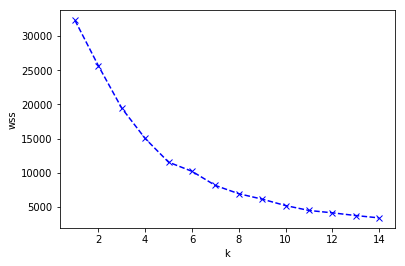

In [19]:
# Elbow plot
plt.plot(range(1,15), wss, 'bx--')
plt.xlabel('k')
plt.ylabel('wss')
plt.show()

In [20]:
# Fitting the model with 5 clusters.
km = KMeans(n_clusters=5, random_state=45, n_init=200,max_iter= 2000)
model = km.fit(customer_data_stan)

kmeans_clusters = model.predict(customer_data_stan)
final_data = pd.DataFrame(kmeans_clusters)
final_data['CustomerID'] = Labels
final_data = final_data.rename(columns=({0:'Segment'}))
customer_data_final = customer_data.merge(final_data, how='inner', on='CustomerID')

In [21]:
customer_data_final.head()

,CustomerID,UnitPrice,Recency,Frequency,DaysBtwVisit,Segment
0,12346,2.08,347,148430,0.000000,2
1,12347,481.21,24,2458,1.738889,0
2,12348,178.71,97,2341,8.379310,0
3,12349,605.10,40,631,0.000000,0
4,12350,65.30,332,197,0.000000,3


In [22]:
customer_data_final.to_csv('kmeans_output.csv', index=False)

### RFM Analysis

Text(0,0.5,'Frequency')

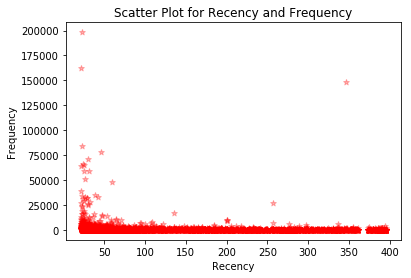

In [23]:
#Recency vs Frequency
plt.scatter(customer_data.groupby('CustomerID')['Recency'].sum(), customer_data.groupby('CustomerID')['Frequency'].sum(),
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Recency')
plt.ylabel('Frequency')

#### We can see from the above plot that customers whose recency is less than 50 days have high frequency i.e they are buying more when recency is less

Text(0,0.5,'Frequency')

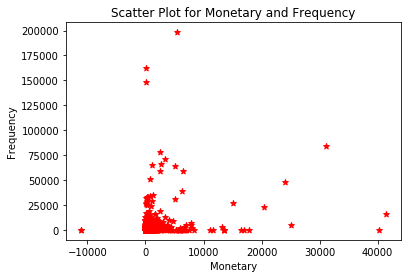

In [24]:
# Frequency vs Monetary value
market_data = customer_data.groupby('CustomerID')[['Frequency', 'UnitPrice']].sum()

plt.scatter(market_data['UnitPrice'], market_data['Frequency'],
            color = 'red',
            marker = '*', alpha = 1)

plt.title('Scatter Plot for Monetary and Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')

#### From the above plot we can observe that monetary value is less when frequency is less

Text(0,0.5,'Frequency')

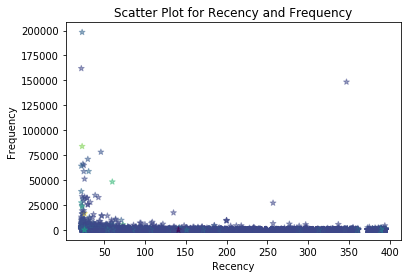

In [25]:
# Recency vs Ferequency vs Monetary value
Monetary = customer_data.groupby('CustomerID')['UnitPrice'].sum()
plt.scatter(customer_data.groupby('CustomerID')['Recency'].sum(), customer_data.groupby('CustomerID')['Frequency'].sum(),
            marker = '*', alpha = 0.5,c=Monetary)

plt.title('Scatter Plot for Recency and Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')

In [63]:
#Creating the quartiles for Recency, frequency and monetary values and defining the segments based on their descriptive stats
rfm2 = customer_data.copy()
rfm2['r_quartile'] = pd.qcut(rfm2['Recency'], 3, ['3','2','1'])
rfm2['f_quartile'] = pd.qcut(rfm2['Frequency'], 3, ['3','2','1'])
rfm2['m_quartile'] = pd.qcut(rfm2['UnitPrice'], 3, ['1','2','3'])

rfm2['RFM_Score'] = rfm2.r_quartile.astype(str)+ rfm2.f_quartile.astype(str) + rfm2.m_quartile.astype(str)
rfm2['Segment'] = ''
for i in range(len(rfm2)):
    if rfm2['RFM_Score'][i] == '333':
        rfm2['Segment'][i] = 'Best Customers'
    elif rfm2['RFM_Score'][i] == '332' or rfm2['RFM_Score'][i] == '331' or rfm2['RFM_Score'][i] == '323' or rfm2['RFM_Score'][i] == '313':
        rfm2['Segment'][i] = 'Potential Loyal Customers'
    elif rfm2['RFM_Score'][i] == '321' or rfm2['RFM_Score'][i] == '322' or rfm2['RFM_Score'][i] == '311' or rfm2['RFM_Score'][i] == '312' or rfm2['RFM_Score'][i] == '233':
        rfm2['Segment'][i] = 'New Customers'
    elif rfm2['RFM_Score'][i] == '223' or rfm2['RFM_Score'][i] == '213' or rfm2['RFM_Score'][i] == '212' or rfm2['RFM_Score'][i] == '231' or rfm2['RFM_Score'][i] == '232' or rfm2['RFM_Score'][i] == '211' or rfm2['RFM_Score'][i] == '221' or rfm2['RFM_Score'][i] == '222':
        rfm2['Segment'][i] = 'At Risk Customers'
    elif rfm2['RFM_Score'][i] == '132' or rfm2['RFM_Score'][i] == '123' or rfm2['RFM_Score'][i] == '113' or rfm2['RFM_Score'][i] == '133' or rfm2['RFM_Score'][i] == '111' or rfm2['RFM_Score'][i] == '112' or rfm2['RFM_Score'][i] == '121' or rfm2['RFM_Score'][i] == '122' or rfm2['RFM_Score'][i] == '131':
        rfm2['Segment'][i] = 'Churned Customers'

In [28]:
rfm2.to_csv('RFM_output.csv', index=False)

### Implementing K-Medoids

In [29]:
#Checking the SSE for a range of clusters to finalize on the number of clusters
wss = []
for k in range(1,20):
    km = KMedoids(n_clusters=k)
    km.fit(customer_data_stan)
    wss.append(km.inertia_)

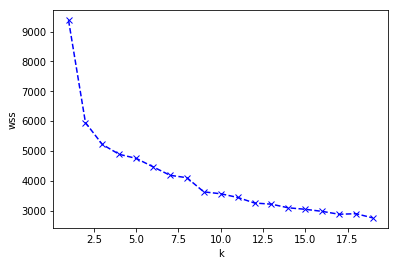

In [30]:
# Elbow plot
plt.plot(range(1,20), wss, 'bx--')
plt.xlabel('k')
plt.ylabel('wss')
plt.show()

In [36]:
# Fitting the model with 5 clusters.
km = KMedoids(n_clusters=5, method='pam', max_iter=1500, random_state=12)
model = km.fit(customer_data_stan)

kmedoid_clusters = model.predict(customer_data_stan)
kd_final_data = pd.DataFrame(kmedoid_clusters)
kd_final_data['CustomerID'] = Labels
kd_final_data = kd_final_data.rename(columns=({0:'Segment'}))
kd_customer_data_final = customer_data.merge(kd_final_data, how='inner', on='CustomerID')

In [37]:
kd_customer_data_final.to_csv('Kmedoids_output.csv', index=False)

### Training an ML model on the labeled data

In [64]:
#Converting the labels to numeric
rfm2['Label'] = ''
for i in range(len(rfm2)):
    if rfm2['Segment'][i] == 'Best Customers':
        rfm2['Label'][i] = 0
    elif rfm2['Segment'][i] == 'Potential Loyal Customers':
        rfm2['Label'][i] = 1
    elif rfm2['Segment'][i] == 'New Customers':
        rfm2['Label'][i] = 2
    elif rfm2['Segment'][i] == 'At Risk Customers':
        rfm2['Label'][i] = 3
    elif rfm2['Segment'][i] == 'Churned Customers':
        rfm2['Label'][i] = 4
rfm2.head()

,CustomerID,UnitPrice,Recency,Frequency,DaysBtwVisit,r_quartile,f_quartile,m_quartile,RFM_Score,Segment,Label
0,12346,2.08,347,148430,0.000000,1,1,1,111,Churned Customers,4
1,12347,481.21,24,2458,1.738889,3,1,3,313,Potential Loyal Customers,1
2,12348,178.71,97,2341,8.379310,2,1,3,213,At Risk Customers,3
3,12349,605.10,40,631,0.000000,3,1,3,313,Potential Loyal Customers,1
4,12350,65.30,332,197,0.000000,1,2,2,122,Churned Customers,4


In [67]:
rfm2['Label'] = rfm2['Label'].astype(int)
y = rfm2[['Label']]
rfm3 = rfm2.drop(['Segment','RFM_Score','Label','r_quartile','f_quartile','m_quartile'], axis=1)

In [68]:
#Splitting data into train and test
X_train,X_test,y_train,y_test = train_test_split(rfm3, y, test_size = 0.3, random_state = 100, stratify=y)

# Decoupling the target from the data
X_train1 = X_train.drop('CustomerID', axis=1)
X_test1 = X_test.drop('CustomerID', axis=1)

#Standardizing the dataset
scaler = StandardScaler()
X_train_stan = scaler.fit_transform(X_train1)
X_test_stan = scaler.transform(X_test1)

### Random Forest

In [69]:
#Hyper parameter tuning of the Random Forest Model
rfc_grid = RandomForestClassifier(class_weight='balanced')
 

param_grid = {"n_estimators" :np.arange(100,500, 50),
              "max_depth" :np.arange(3,8,1),
             "min_samples_leaf" :np.arange(2,14,2),
             "min_samples_split":np.arange(2,16,2)}
 
rfc_cv_grid = RandomizedSearchCV(estimator = rfc_grid, param_distributions = param_grid, cv = 4,n_jobs=-1)
rfc_cv_grid.fit(X_train_stan, y_train)
rfc_final = rfc_cv_grid.best_estimator_.fit(X_train_stan, y_train)

In [70]:
#Predicting on train and test and checking the model performance
rfc_train_pred = rfc_final.predict(X_train_stan)
rfc_test_pred = rfc_final.predict(X_test_stan)

print("Train")
print(accuracy_score(y_train,rfc_train_pred))
print(confusion_matrix(y_train,rfc_train_pred))
print(classification_report(y_train,rfc_train_pred))


print("Test")
print(accuracy_score(y_test,rfc_test_pred))
print(confusion_matrix(y_test,rfc_test_pred))
print(classification_report(y_test,rfc_test_pred))

Train
0.9998232278592893
[[  11    0    0    0    0]
 [   0 1225    0    0    0]
 [   0    0  718    1    0]
 [   0    0    0 1830    0]
 [   0    0    0    0 1872]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00      1225
           2       1.00      1.00      1.00       719
           3       1.00      1.00      1.00      1830
           4       1.00      1.00      1.00      1872

    accuracy                           1.00      5657
   macro avg       1.00      1.00      1.00      5657
weighted avg       1.00      1.00      1.00      5657

Test
0.9995876288659794
[[  5   0   0   0   0]
 [  0 525   0   0   0]
 [  0   0 308   1   0]
 [  0   0   0 784   0]
 [  0   0   0   0 802]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00       525
           2       1.00      1.00      1.0

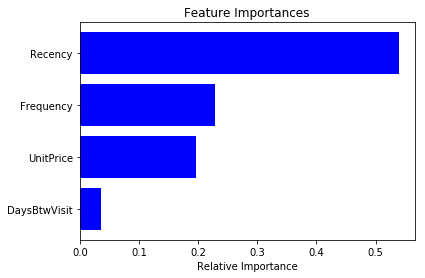

In [71]:
#Checking the feature importance
features = X_test1.columns
importances = rfc_final.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [72]:
rf_test_predictions = pd.DataFrame({"CustomerID":X_test['CustomerID'],"Label":rfc_final.predict(X_test_stan)})
rf_test_predictions.Label.value_counts()

4    802
3    785
1    525
2    308
0      5
Name: Label, dtype: int64

In [73]:
rf_test_predictions.to_csv('rf_predictions.csv', index=False)

### XGBoost

In [74]:
#Hyper parameter tuning of the XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', n_jobs=8)

param_grid = {'n_estimators':np.arange(50,200,50),
              'max_depth':np.arange(2,10,1),
              'learning_rate':np.arange(0.0001,1, 0.001),
              'gamma':np.arange(0.1,0.5,0.05)}
 
xgb_model_cv_grid = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, cv = 5, n_iter=250)
xgb_model_cv_grid.fit(X_train_stan, y_train)
xgb_model = xgb_model_cv_grid.best_estimator_.fit(X_train_stan,y_train)

[23:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:10:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:10:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:11:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:12:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:12:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:12:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:14:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:14:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:15:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:15:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:16:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:17:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [75]:
#Predicting on train and test sets and checking the model performance
xgb_trainpreds = xgb_model.predict(X_train_stan)
xgb_testpreds = xgb_model.predict(X_test_stan)
print("Train")
print(accuracy_score(y_train,xgb_trainpreds))
print(confusion_matrix(y_train,xgb_trainpreds))
print(classification_report(y_train,xgb_trainpreds))


print("Test")
print(accuracy_score(y_test,xgb_testpreds))
print(confusion_matrix(y_test,xgb_testpreds))
print(classification_report(y_test,xgb_testpreds))

Train
1.0
[[  11    0    0    0    0]
 [   0 1225    0    0    0]
 [   0    0  719    0    0]
 [   0    0    0 1830    0]
 [   0    0    0    0 1872]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00      1225
           2       1.00      1.00      1.00       719
           3       1.00      1.00      1.00      1830
           4       1.00      1.00      1.00      1872

    accuracy                           1.00      5657
   macro avg       1.00      1.00      1.00      5657
weighted avg       1.00      1.00      1.00      5657

Test
1.0
[[  5   0   0   0   0]
 [  0 525   0   0   0]
 [  0   0 309   0   0]
 [  0   0   0 784   0]
 [  0   0   0   0 802]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00       525
           2       1.00      1.00      1.00       309
           3      

In [76]:
xgb_test_predictions = pd.DataFrame({"CustomerID":X_test['CustomerID'],"Label":xgb_model.predict(X_test_stan)})
xgb_test_predictions.Label.value_counts()

4    802
3    784
1    525
2    309
0      5
Name: Label, dtype: int64

In [77]:
xgb_test_predictions.to_csv("xgb_predictions.csv", index=False)

### Stacking

In [80]:
## Stacking
rf_train_pred1 = rfc_final.predict(X_train_stan)
xgb_train_pred1 = xgb_model.predict(X_train_stan)

meta_learner_data = pd.DataFrame({"RF":rf_train_pred1,"XGB":xgb_train_pred1})

In [81]:
#Building a metalearner and predicting on the test set
svc_grid = SVC(class_weight='balanced', max_iter=150)
stack_model = svc_grid.fit(meta_learner_data,y_train)

stack_trainpred = stack_model.predict(meta_learner_data)

## Test Predictions
rf_test_pred1 = rfc_final.predict(X_test_stan)
xgb_test_pred1 = xgb_model.predict(X_test_stan)

meta_learner_test_data = pd.DataFrame({"RF":rf_test_pred1, "XGB":xgb_test_pred1})

stack_testpreds = stack_model.predict(meta_learner_test_data)

In [82]:
#Checking the performance of the stack model
print("Train")
print(accuracy_score(y_train,stack_trainpred))
print(confusion_matrix(y_train,stack_trainpred))
print(classification_report(y_train,stack_trainpred))

print("Test")
print(accuracy_score(y_test,stack_testpreds))
print(confusion_matrix(y_test,stack_testpreds))
print(classification_report(y_test,stack_testpreds))

Train
1.0
[[  11    0    0    0    0]
 [   0 1225    0    0    0]
 [   0    0  719    0    0]
 [   0    0    0 1830    0]
 [   0    0    0    0 1872]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00      1225
           2       1.00      1.00      1.00       719
           3       1.00      1.00      1.00      1830
           4       1.00      1.00      1.00      1872

    accuracy                           1.00      5657
   macro avg       1.00      1.00      1.00      5657
weighted avg       1.00      1.00      1.00      5657

Test
1.0
[[  5   0   0   0   0]
 [  0 525   0   0   0]
 [  0   0 309   0   0]
 [  0   0   0 784   0]
 [  0   0   0   0 802]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00       525
           2       1.00      1.00      1.00       309
           3      

In [83]:
#Saving predicitions to a csv file.
stack_test_predictions = pd.DataFrame({"CustomerID":X_test['CustomerID'],"Label":stack_model.predict(meta_learner_test_data)})
stack_test_predictions.to_csv("stack_predictions.csv", index=False)